In [83]:
import psycopg2 as pg
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Retrieves the data from the postgres db

In [84]:
# connect to the db
con = pg.connect(
    database = 'securities_master', 
    user = 'postgres', 
    )
cur = con.cursor()

command = """SELECT price_date, adj_close_price, ticker, exchange_id FROM daily_price
                JOIN symbol ON daily_price.symbol_id = symbol.id 
                WHERE exchange_id = 5 and price_date BETWEEN 
                   date '1999-12-31' and 
                   date '2014-12-31';"""

cur.execute(command)
rows = cur.fetchall()

# close the cursor and connection
cur.close()
con.close()

In [85]:
yday = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')

### Reformats the data so that tickers are column headers

In [86]:
# reformats the table
df = pd.DataFrame(rows, columns = ['date', 'price', 'ticker', 'exchange_id'])
df['price'] = pd.to_numeric(df['price'])
df = df.pivot_table(index = 'date', columns = 'ticker', values = 'price')
df.index = pd.to_datetime(df.index)

# Analysis

In [87]:
num_hldg = 30

returns = df.pct_change()
cum_returns = np.cumprod(1 + returns) - 1

monthly_price = df.resample('BM').last()
monthly_returns = monthly_price.pct_change().fillna(0)

### Picks the top 30 performing strategies based on monthly returns

In [88]:
# creates the positions df
positions = pd.DataFrame(index = monthly_returns.index, columns = monthly_returns.columns)
positions.loc[:,:] = 0

for month in monthly_returns[1:].index:
    sorted_list = monthly_returns.loc[month,:].sort_values(ascending = False)
    buy_list = sorted_list[sorted_list < 1][:num_hldg]
    positions.loc[month, buy_list.index] = 1 / num_hldg

### Perfomance

count    181.000000
mean       0.041467
std        0.305724
min       -0.134919
25%       -0.013807
50%        0.012951
75%        0.034432
max        2.946816
dtype: float64
0.32439441917936374 0.47115371853481913


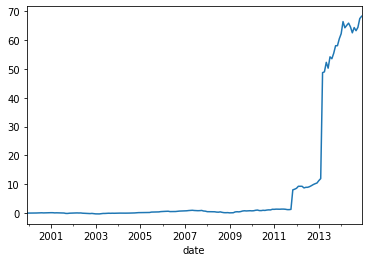

In [89]:
portfolio_returns = positions.shift() * monthly_returns
total_porfolio_returns = portfolio_returns.sum(axis = 1)
cum_portfolio_returns = np.cumprod(1 + total_porfolio_returns) - 1
cum_portfolio_returns.plot()


apr = np.prod(1 + total_porfolio_returns) ** (12 / len(total_porfolio_returns)) - 1
sharpe = np.mean(total_porfolio_returns) / np.std(total_porfolio_returns) * np.sqrt(12)

print(total_porfolio_returns.describe())
print(apr, sharpe)